In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import numpy as np
from pathlib import Path
from torchsummary import summary
torch.set_printoptions(sci_mode=False)

In [3]:
PATH = Path("dataset") / "GTSRB" / "Training"
torch.set_float32_matmul_precision('high')
LABELS = ["20 km/h"
,"30 km/h"
,"50 km/h"
,"60 km/h"
,"70 km/h"
,"80 km/h"
,"End of speed limit"
,"100 km/h"
,"120 km/h"
,"No passing"
,"No passing for large vehicles"
,"Right of way"
,"Priority road"
,"Yield"
,"Stop"
,"No vehicles"
,"Large vehicles prohibited"
,"No entry"
,"General caution"
,"Dangerous curve to the left"
,"Dangerous curve to the right"
,"Double curve"
,"Bumpy road"
,"Slippery road"
,"Road narrows"
,"Road work"
,"Traffic signals"
,"Pedestrians"
,"Children crossing"
,"Bicycle crossing"
,"Ice warning"
,"Wild animals crossing"
,"End of all speed and passing limits"
,"Turn right ahead"
,"Turn left ahead"
,"Ahead only"
,"Go straight or right"
,"Go straight or left"
,"Keep right"
,"Keep left"
,"Roundabout mandatory"
,"End of no passing"
,"End of no passing by large vehicles"]

In [4]:
_N = 32
batch_size = 256
n_classes = 43
epochs = 30
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
def get_mean_std():
    transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    ])
    dataset = torchvision.datasets.ImageFolder(root=PATH,transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total = 0
    for images,_ in dataloader: # load a batch at a time
        n = images.size(0)
        total += 1
        mean  += images.mean(dim=[0,2,3])
        std   += images.std(dim=[0,2,3])
    std  /= total
    mean /= total
    return mean,std
# get_mean_std() # (tensor([0.3397, 0.3117, 0.3210]), tensor([0.2299, 0.2247, 0.2332]))

In [6]:
mean = torch.tensor([0.3397, 0.3117, 0.3210])
std = torch.tensor([0.2299, 0.2247, 0.2332])

def to_image(img): # convert to unormalized form for viewing
    _mean = mean.view(3,1,1)
    _std = std.view(3,1,1)
    return (img * _std + _mean).permute(1,2,0).numpy()
normalise = transforms.Normalize(mean, std)
transform = transforms.Compose([
    transforms.Resize((_N,_N)),
    transforms.ToTensor(),
    normalise
])

In [7]:
dataset = torchvision.datasets.ImageFolder(root=PATH, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           num_workers=6,
                                           shuffle=True
                                           )
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          num_workers=6,
                                          shuffle=False
                                          )

/home/robm/Code/Project/env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


No passing


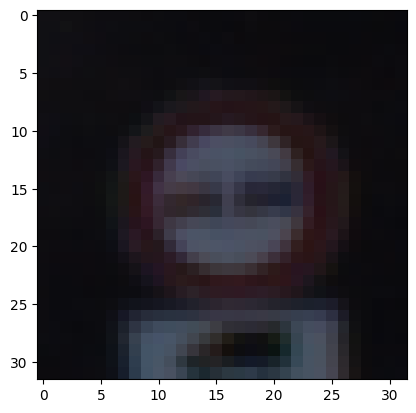

In [8]:
for img,label in train_loader:
    img = to_image(img[0])
    plt.imshow(img)
    print(LABELS[label[0]])
    break

In [8]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        x = torch.zeros((64,3,_N,_N))
        self.activation = torch.nn.functional.relu
        self.pool = torch.nn.MaxPool2d(2,2)

        self.conv1 = torch.nn.Conv2d(3,6,5)
        x = self.pool(self.activation(self.conv1(x)))
        
        self.conv2 = torch.nn.Conv2d(x.shape[1],16,5)
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        self.dense1 = torch.nn.Linear(x.shape[1],128)
        x = self.activation(self.dense1(x))
        self.dense2 = torch.nn.Linear(x.shape[1],64)
        x = self.activation(self.dense2(x))
        self.final = torch.nn.Linear(x.shape[1],n_classes)


    def forward(self,x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        
        x = torch.flatten(x, start_dim=1)

        x = self.activation(self.dense1(x))
        x = self.activation(self.dense2(x))
        x = self.final(x)

        return x
        
model = torch.compile(Model()).to(device)
summary(model,(3,32,32),batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [256, 6, 28, 28]             456
         MaxPool2d-2           [256, 6, 14, 14]               0
            Conv2d-3          [256, 16, 10, 10]           2,416
         MaxPool2d-4            [256, 16, 5, 5]               0
            Linear-5                 [256, 128]          51,328
            Linear-6                  [256, 64]           8,256
            Linear-7                  [256, 43]           2,795
             Model-8                  [256, 43]               0
Total params: 65,251
Trainable params: 65,251
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.00
Forward/backward pass size (MB): 15.93
Params size (MB): 0.25
Estimated Total Size (MB): 19.18
----------------------------------------------------------------


In [9]:
loss_func = torch.nn.CrossEntropyLoss().to(device)
optimiser = torch.optim.Adam(model.parameters())#torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

In [10]:
len(test_loader)

31

In [11]:

def train(model,loss_func,optimiser):
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimiser.zero_grad()
            preds = model(images)
            loss = loss_func(preds, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} --- Training Loss {total_loss / len(train_loader):.3f} --- Validation Loss {test_performance(model,loss_func):.3f}")

def test_performance(model,loss_func):
    loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            loss += loss_func(preds,labels).item()
    return loss / len(test_loader)

In [12]:
train(model,loss_func,optimiser)

/home/robm/Code/Project/env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/robm/Code/Project/env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1 --- Training Loss 2.542 --- Validation Loss 1.389


/home/robm/Code/Project/env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 2 --- Training Loss 0.920 --- Validation Loss 0.643
Epoch 3 --- Training Loss 0.494 --- Validation Loss 0.429
Epoch 4 --- Training Loss 0.331 --- Validation Loss 0.291
Epoch 5 --- Training Loss 0.243 --- Validation Loss 0.232
Epoch 6 --- Training Loss 0.189 --- Validation Loss 0.193
Epoch 7 --- Training Loss 0.148 --- Validation Loss 0.175
Epoch 8 --- Training Loss 0.122 --- Validation Loss 0.169
Epoch 9 --- Training Loss 0.101 --- Validation Loss 0.123
Epoch 10 --- Training Loss 0.082 --- Validation Loss 0.150
Epoch 11 --- Training Loss 0.074 --- Validation Loss 0.111
Epoch 12 --- Training Loss 0.059 --- Validation Loss 0.137
Epoch 13 --- Training Loss 0.051 --- Validation Loss 0.104
Epoch 14 --- Training Loss 0.047 --- Validation Loss 0.105
Epoch 15 --- Training Loss 0.040 --- Validation Loss 0.103
Epoch 16 --- Training Loss 0.033 --- Validation Loss 0.127
Epoch 17 --- Training Loss 0.029 --- Validation Loss 0.093
Epoch 18 --- Training Loss 0.022 --- Validation Loss 0.095
Epoch

In [13]:
def evaluate(model):
    predictions = []
    labels = []
    with torch.no_grad():
        for images,lbls in test_loader:
            labels.extend(lbls.numpy())
            
            images = images.to(device)
            preds = model(images)
            predictions.extend(preds.cpu().numpy())
            
    labels = np.array(labels)
    predictions = np.array(predictions)
    pred_class = np.argmax(predictions,axis=1)
    precision = precision_score(labels, pred_class, average="weighted")
    recall = recall_score(labels, pred_class, average="weighted")
    f1 = f1_score(labels, pred_class, average="weighted")
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')
evaluate(model)

Precision (macro): 0.9724
Recall (macro): 0.9709
F1-score (macro): 0.9709


In [ ]:
for img,_ in train_loader:
    epsilon = (std / std).reshape(1,3,1,1)
    print(epsilon)
    print(img[0,0])
    print((img+epsilon)[0,0]) # Todo this work?!
    break

tensor([[[[1.]],

         [[1.]],

         [[1.]]]])
tensor([[-1.1535, -1.1706, -1.1535,  ..., -1.1535, -1.1535, -1.1535],
        [-1.1706, -1.1876, -1.1706,  ..., -1.1706, -1.1706, -1.1876],
        [-1.2047, -1.1876, -1.1706,  ..., -1.1706, -1.1706, -1.1535],
        ...,
        [-0.5394, -0.6929, -0.8635,  ..., -0.9659, -1.0000, -1.0682],
        [-0.5906, -0.5224, -0.6418,  ..., -0.8806, -0.8976, -0.9318],
        [-0.4712, -0.3518, -0.5565,  ..., -0.8806, -0.8976, -0.8976]])
tensor([[    -0.1535,     -0.1706,     -0.1535,  ...,     -0.1535,
             -0.1535,     -0.1535],
        [    -0.1706,     -0.1876,     -0.1706,  ...,     -0.1706,
             -0.1706,     -0.1876],
        [    -0.2047,     -0.1876,     -0.1706,  ...,     -0.1706,
             -0.1706,     -0.1535],
        ...,
        [     0.4606,      0.3071,      0.1365,  ...,      0.0341,
              0.0000,     -0.0682],
        [     0.4094,      0.4776,      0.3582,  ...,      0.1194,
              0.102

In [ ]:
@torch.compile
def pgd_attack(model,images,labels,loss_func,iterations,epsilon,alpha):
    # Upper / Lower bounds for an image
    images_upper = normalise(torch.zeros((1,3,1,1)))
    images_lower = normalise(torch.ones((1,3,1,1)))
    # Upper / Lower bounds within the epsilon ball
    epsilon = (epsilon / std).reshape(1,3,1,1)
    epsilon_upper = images + epsilon
    epsilon_lower = images - epsilon

    decay = torch.logspace(alpha,1,iterations,2)
    decay = decay / decay[0]

    adversarial = images # Double check if this edits originals
    adversarial.requires_grad = True

    for alpha in decay:
        model.zero_grad()
        pred = model(adversarial)
        loss = loss_func(pred,labels)
        #print(loss.item())
        loss.backward()
        # TODO - Edit Learning Rate / Apply Adam Optimiser
        perturbations = torch.sign(adversarial.grad.data) * epsilon * alpha
        adversarial += perturbations
        adversarial = torch.clip(adversarial,epsilon_lower, epsilon_upper)
        adversarial = torch.clip(adversarial,images_lower,images_upper)

    return normalise(adversarial)

normalise.to(device)

@torch.compile
def denormalise(images):
    _mean = mean.view(1,3,1,1).to(device)
    _std = std.view(1,3,1,1).to(device)
    return images * _std + _mean

/home/robm/Code/Project/env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


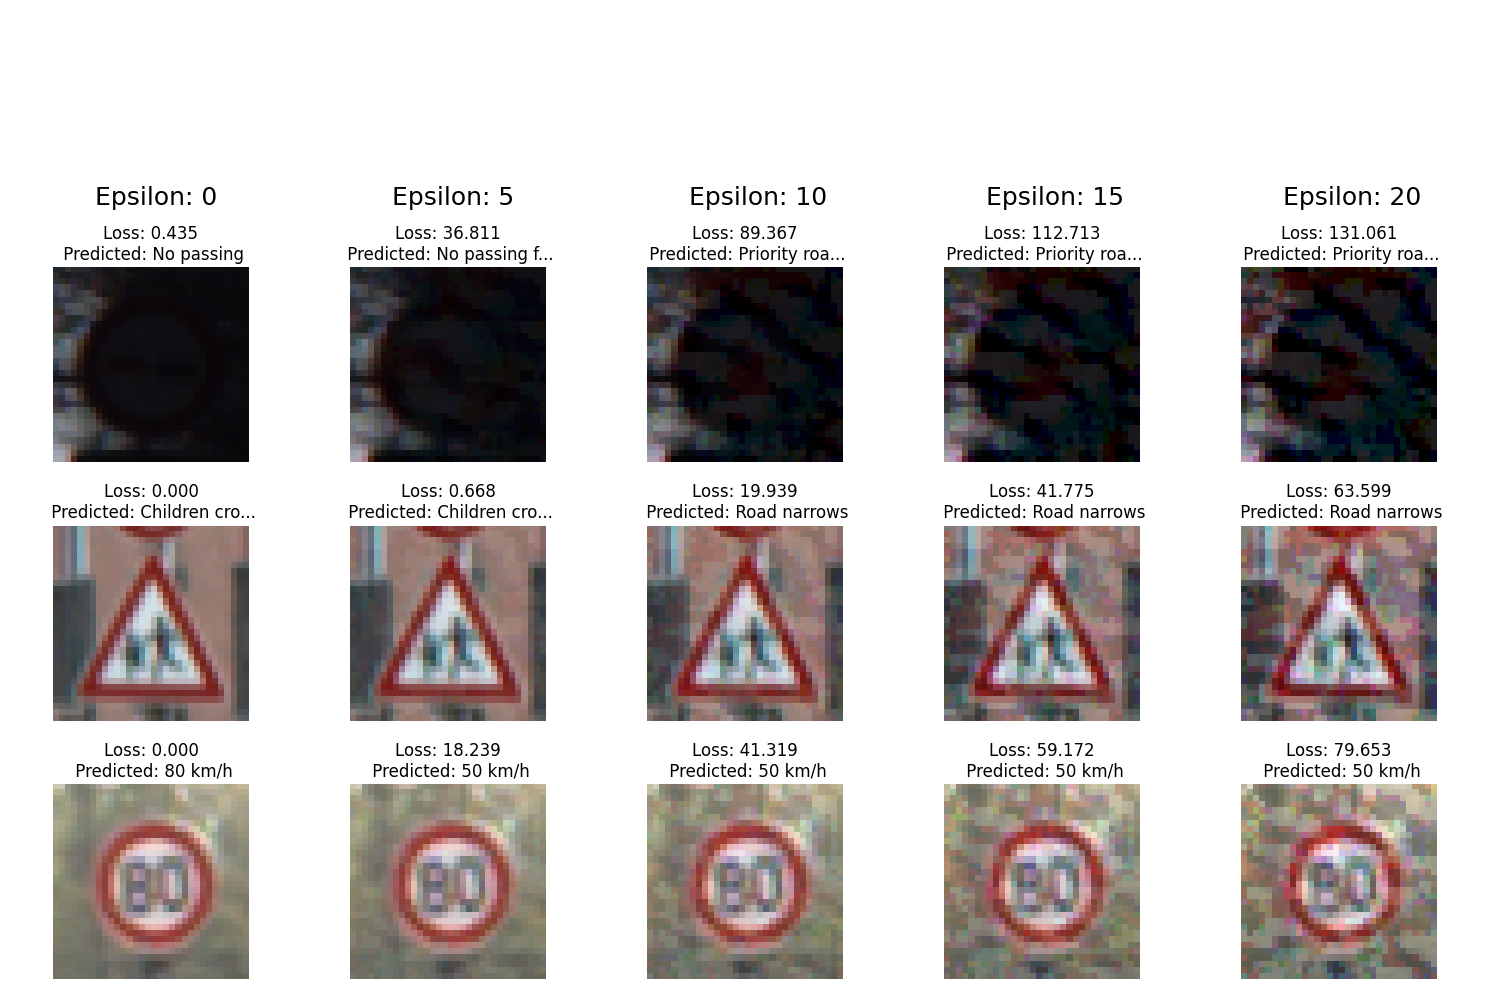

In [15]:
def adversarial_test(model):
    for img,lbl in test_loader:
        img = img.to(device)
        lbl = lbl.to(device)

        """og_pred = model(img)
        adv_pred = model(adv)
        og_loss = loss_func()"""
        #print(f"Set: {epsilon}\nActual: {torch.max(denormalise(img)-denormalise(adv))}")

        rows = 4
        columns = 5
        
        plt.figure(figsize=(15, 10))
        multiplier = 5
        for j in range(columns):
            epsilon = j * multiplier
            plt.subplot(rows, columns, j + 1)
            plt.axis("off")
            plt.text(0.3, 0, f"Epsilon: {epsilon}", fontsize=18)

            

        for j in range(columns):
            epsilon = j * multiplier / 255
            adv = pgd_attack(model,img,lbl,loss_func,50,epsilon,2)
            for i in range(1,rows):
                plt.subplot(rows, columns, i * columns + j + 1)
                pred = model(adv[i].reshape(1,3,_N,_N))
                loss = loss_func(pred,lbl[i].reshape(1)).data
                pred_class = LABELS[torch.argmax(pred)]
                pred_class = pred_class[:12] + "..." if len(pred_class) > 12 else pred_class
                plt.imshow(to_image(adv[i].cpu()))
                plt.title(f"Loss: {loss:.3f}\n Predicted: {pred_class}")
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        # Gets errors for images being out of 0-1 range, probably floating point inaccuracy
        break
adversarial_test(model)

In [ ]:
def adversarial_training(model,loss_func,optimiser,iterations,epsilon,alpha):
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            images = torch.cat((images,
                pgd_attack(model,images,labels,loss_func,iterations,epsilon,alpha)
                ))
            labels = torch.cat((labels,labels))

            optimiser.zero_grad()
            preds = model(images)
            loss = loss_func(preds, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} --- Training Loss {total_loss / len(train_loader):.3f} --- Validation Loss {test_performance(model,loss_func):.3f}")


In [19]:
adversarial_model = torch.compile(Model()).to(device)
adv_optimiser = torch.optim.Adam(adversarial_model.parameters())#torch.optim.SGD(adversarial_model.parameters(),lr=0.01, momentum=0.9)

In [20]:
epochs = 15
adversarial_training(adversarial_model,loss_func,adv_optimiser,20,10/255,2) # 20 mins -> 60 epochs

Epoch 1 --- Training Loss 3.317 --- Validation Loss 2.463
Epoch 2 --- Training Loss 2.338 --- Validation Loss 1.517
Epoch 3 --- Training Loss 1.902 --- Validation Loss 1.198
Epoch 4 --- Training Loss 1.735 --- Validation Loss 1.050
Epoch 5 --- Training Loss 1.633 --- Validation Loss 0.974
Epoch 6 --- Training Loss 1.562 --- Validation Loss 0.915
Epoch 7 --- Training Loss 1.506 --- Validation Loss 0.860
Epoch 8 --- Training Loss 1.466 --- Validation Loss 0.818
Epoch 9 --- Training Loss 1.435 --- Validation Loss 0.806
Epoch 10 --- Training Loss 1.408 --- Validation Loss 0.762
Epoch 11 --- Training Loss 1.384 --- Validation Loss 0.730
Epoch 12 --- Training Loss 1.369 --- Validation Loss 0.734
Epoch 13 --- Training Loss 1.354 --- Validation Loss 0.705
Epoch 14 --- Training Loss 1.334 --- Validation Loss 0.680
Epoch 15 --- Training Loss 1.322 --- Validation Loss 0.689


In [21]:
evaluate(adversarial_model)

Precision (macro): 0.8743
Recall (macro): 0.8542
F1-score (macro): 0.8546


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.7843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.71372545].


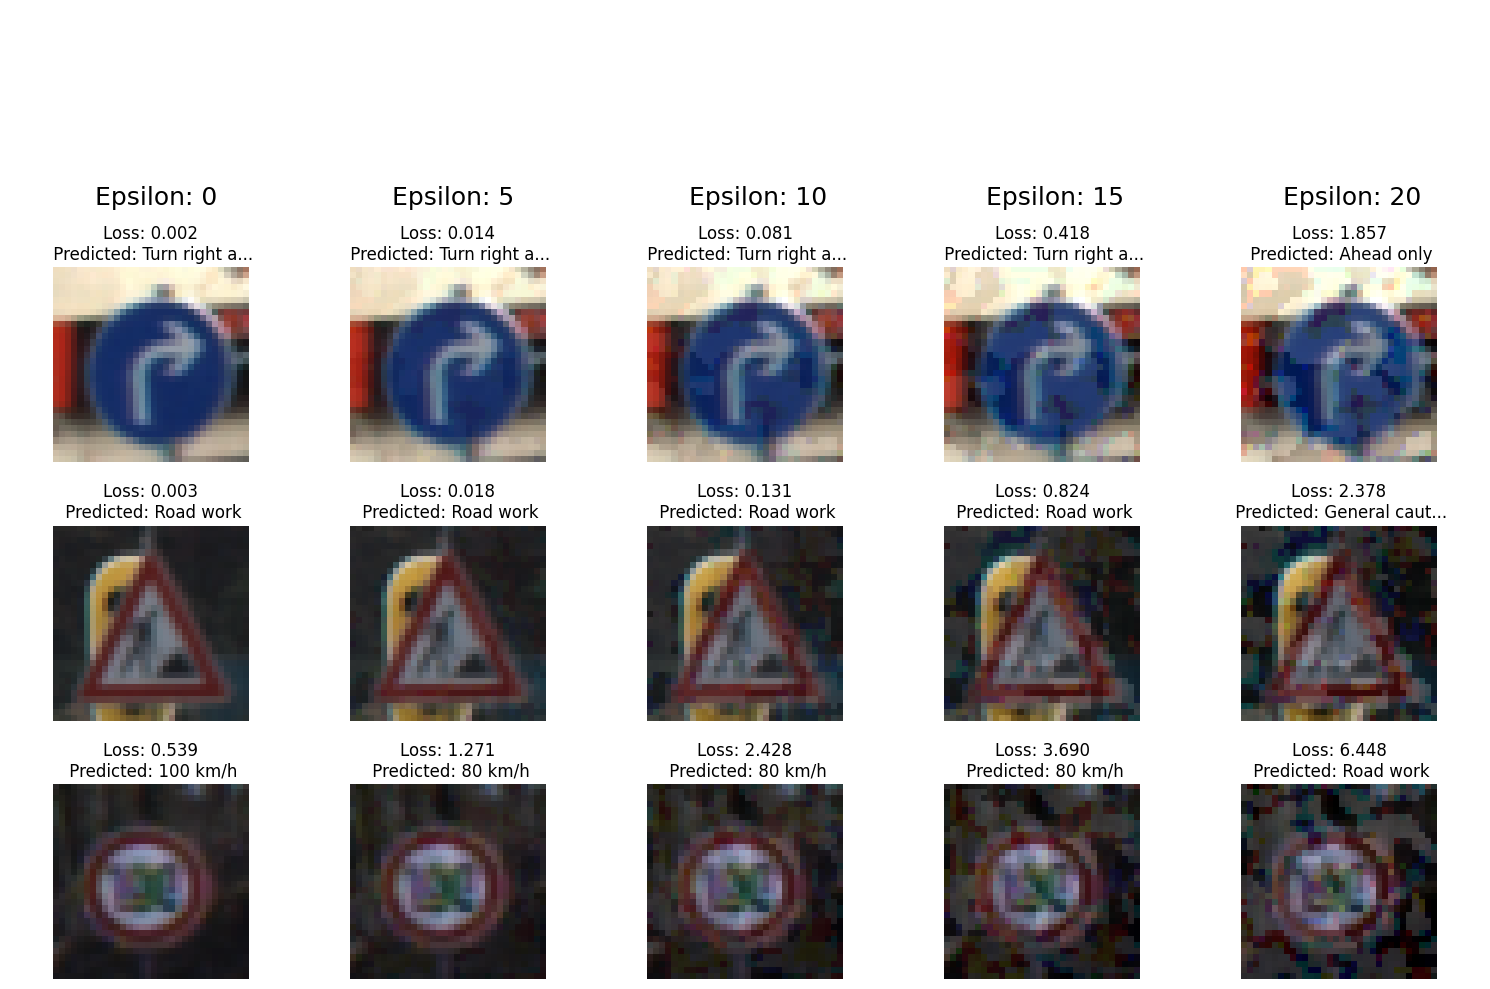

In [22]:
adversarial_test(adversarial_model)

In [27]:
torch.save(adversarial_model.state_dict(),"models/adversarial_model")